In [ ]:
## NEW AND CLEAN NOTEBOOK, FINAL

In [ ]:
!pip install pandas matplotlib datetime yfinance numpy scipy scikit-learn pandas_market_calendars numpy pycopula



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as DT
import yfinance as yf
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import pandas_market_calendars as mcal
import datetime
import scipy as sp
import scipy.interpolate
from scipy.stats import norm
import math

import numpy as np
import pandas as pd
from scipy.stats import t, norm
from pycopula.copula import GaussianCopula

## Data Import

In [ ]:
file_path = "../Data CSV/VIX.csv"
vix = pd.read_csv(file_path)
vix.set_index("Date", inplace = True)
vix.index = pd.DatetimeIndex(vix.index)
vix = vix["Price"]
vix.sort_index(ascending= False, inplace = True)

file_path = "../Data CSV/VSTOXX.csv"
vstoxx = pd.read_csv(file_path)
vstoxx.set_index("Date", inplace = True)
vstoxx.index = pd.DatetimeIndex(vstoxx.index)
vstoxx = vstoxx["Price"]
vstoxx.sort_index(ascending= False, inplace = True)


file_path = "../Data CSV/VSMI.csv"
vsmi = pd.read_csv(file_path)
x = np.array([(i.split(";")[0],i.split(";")[2]) for i in list(vsmi["Date;ISIN;Indexvalue"])])
x[:,1] = np.float16(x[:,1])
x[:,0] = [pd.to_datetime(i) for i in x[:,0]]
vsmi = pd.DataFrame(data= {"Price":np.float16(x[:,1])}, index= [pd.to_datetime(i) for i in x[:,0]])
vsmi.dropna(inplace= True)
vsmi.sort_index(ascending= False, inplace = True)

vol_index = {
    "SP500":vix,
    "STOXX50": vstoxx,
    "SMI": vsmi}


/var/folders/dm/bf8cjc0d25n75cy02jj4ms940000gn/T/ipykernel_82150/407778646.py:20: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  x[:,0] = [pd.to_datetime(i) for i in x[:,0]]


In [ ]:
final_date = pd.to_datetime('2024-09-26')
start_date = pd.to_datetime('2024-01-01')

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data['Log Return'] = np.log(data['Price'] / data['Price'].shift(1))
    data = data.dropna(subset=['Log Return'])
    data = data[data.index > "2020-01-01"]
    return data

file_path = "../Data CSV/SMI Historical Data.csv"
smi = load_data(file_path)

file_path = "../Data CSV/S&P 500 Historical Data.csv"
sp500 = load_data(file_path)

file_path = "../Data CSV/Euro Stoxx 50 Historical Data.csv"
stoxx50 = load_data(file_path)

common_dates = list(set(stoxx50.index).intersection(set(smi.index).intersection(set(sp500.index))))
## losing data on dates, simulation also assuming common dates, losing about 14% data
print("Data Loss:", (3*len(common_dates))/(len(stoxx50)+len(smi)+len(sp500)))

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data = data[data.index.isin(common_dates)]
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data['Log Return'] = np.log(data['Price'] / data['Price'].shift(1))
    data.drop(columns=["Change %"], errors = "Ignore", inplace = True)
    data = data.dropna(subset=['Log Return'])
    return data

file_path = "../Data CSV/SMI Historical Data.csv"
smi = load_data(file_path)

file_path = "../Data CSV/S&P 500 Historical Data.csv"
sp500 = load_data(file_path)

file_path = "../Data CSV/Euro Stoxx 50 Historical Data.csv"
stoxx50 = load_data(file_path)

returns = pd.DataFrame({
    'SMI': smi['Log Return'],
    'STOXX50': stoxx50['Log Return'],
    'SP500': sp500['Log Return']
}).dropna()

chf = pd.read_csv("../Data CSV/USD_CHF Historical Data.csv")
chf.index = pd.DatetimeIndex(chf["Date"])
eur = pd.read_csv("../Data CSV/USD_EUR Historical Data.csv")
eur.index = pd.DatetimeIndex(eur["Date"])

## Divide to convert chf to usd, multiply for other way

dates = pd.bdate_range(start=start_date,end=final_date)

interest_rates = pd.read_excel("../Data CSV/US Interest Rates.xlsx")
interest_rates.columns = interest_rates.columns.str.strip()
interest_rates = interest_rates.dropna(subset=["United States Treasury 10-YR Rates"])
interest_rates["United States Treasury 10-YR Rates"] = pd.to_numeric(
    interest_rates["United States Treasury 10-YR Rates"], errors="coerce"
)
interest_rates.index = pd.DatetimeIndex(interest_rates["Dates"])
full_date_range = pd.date_range(start=interest_rates.index.min(), end=interest_rates.index.max())
interest_rates = interest_rates.reindex(full_date_range).ffill()
interest_rates.index.name = "Dates"
interest_rates.head()

r = interest_rates["United States Treasury 10-YR Rates"].dropna()
r = np.log(1+0.01*r)

sp500_init_level = 3977
stoxx_init_level_local = 4164
smi_init_level_local = 10786
##Double checked
dt = 1/252


Data Loss: 0.970348204570185


In [ ]:
def calculate_pv_interest(start_date, risk_free_rate):

    payment_dates = pd.DatetimeIndex(['2023-07-03', '2023-10-03', '2024-01-03', '2024-04-03',
               '2024-07-03', '2024-10-03'],
              dtype='datetime64[ns]', freq=None)

    pv_interest = sum([
        1000 * 0.025 * math.exp(-risk_free_rate * ((payment_date - start_date).days / 365.0))
        for payment_date in payment_dates if payment_date > start_date
    ])

    return pv_interest

In [ ]:
def price_barrier_reverse_convertible(start_date, price_paths ):
    final_date = pd.to_datetime('2024-09-26')
    start_date = pd.to_datetime(start_date)
    T = (final_date - start_date).days / 365.0

    # Converting all the prices to USD
    eur_usd = eur["Price"][start_date]
    chf_usd = chf["Price"][start_date]
    stoxx_init_level = stoxx_init_level_local / eur_usd
    smi_init_level = smi_init_level_local / chf_usd
    sp500_barrier = sp500_init_level * 0.65
    stoxx_barrier = stoxx_init_level * 0.65
    smi_barrier = smi_init_level * 0.65

    payment_dates = [start_date + pd.DateOffset(months=3*i) for i in range(1, 5)]
    payment_dates = [d for d in payment_dates if d <= final_date]

    risk_free_rate = r[r.index <= start_date].iloc[-1]

    pv_interest = calculate_pv_interest(start_date, risk_free_rate)

    discount_factor_maturity = math.exp(-risk_free_rate * T)

    sim_dates = pd.bdate_range(start=start_date, end=final_date)
    sim_length = len(sim_dates)

    num_sims = len(price_paths['SMI'])

    prices = np.zeros(num_sims)
    for i in range(num_sims):
        sim_SMI = np.array(price_paths['SMI'][i][:sim_length])
        sim_SP500 = np.array(price_paths['SP500'][i][:sim_length])
        sim_STOXX50 = np.array(price_paths['STOXX50'][i][:sim_length])

        barrier_breached = (
            (sim_SMI < smi_barrier).any() or
            (sim_SP500 < sp500_barrier).any() or
            (sim_STOXX50 < stoxx_barrier).any()
        )

        if not barrier_breached:
            pv_redemption = 1000 * discount_factor_maturity
        else:

            final_SMI = sim_SMI[-1]
            final_SP500 = sim_SP500[-1]
            final_STOXX50 = sim_STOXX50[-1]

            perf_SMI = final_SMI / smi_init_level
            perf_SP500 = final_SP500 / sp500_init_level
            perf_STOXX50 = final_STOXX50 / stoxx_init_level
            worst_perf = min(perf_SMI, perf_SP500, perf_STOXX50, 1)
            pv_redemption = 1000 * discount_factor_maturity * worst_perf
        price = pv_interest + pv_redemption
        prices[i] = price
    return prices

## Different models

In [ ]:
sigma = {}
for index in ['SMI', 'STOXX50', 'SP500']:
    variance = returns[index].var(ddof= 1)*252
    sigma[index] = np.sqrt(variance)


corr_matrix = returns.corr()
chol_matrix = np.linalg.cholesky(corr_matrix)

price_data = {
        'SMI': smi,
        'STOXX50': stoxx50,
        'SP500': sp500
    }
indices = ['SMI', 'STOXX50', 'SP500']

In [ ]:
def simulate_gbm(start_date, n_simulations = 100000, verbose = False, h_percentage_change = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}):
    dt = 1 / 252

    risk_free_rate = r[r.index <= start_date].iloc[-1]
    n_timesteps = len(dates)

    Z = np.random.normal(size=(n_timesteps, n_simulations, 3))
    Z_flat = Z.reshape(-1, 3)
    Z_correlated_flat = Z_flat @ chol_matrix.T
    Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, 3)
    initial_prices = {}
    for index in indices:
        initial_prices[index] = price_data[index]['Price'][price_data[index].index >= start_date].iloc[-1]
    for i in indices:
        initial_prices[i] *= h_percentage_change.get(i)


    price_paths = {
        'SMI': np.zeros((n_timesteps + 1, n_simulations)),
        'STOXX50': np.zeros((n_timesteps + 1, n_simulations)),
        'SP500': np.zeros((n_timesteps + 1, n_simulations))
    }

    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index][0] = initial_prices[index]

    for i in range(1, n_timesteps + 1):
        for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
            drift_term = (risk_free_rate - 0.5 * sigma[index] ** 2)*dt
            diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
            price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)

    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index]= price_paths[index].transpose()
    T = (final_date-start_date).days/352
    if not verbose:
        return price_paths

    print()
    for i in mu:
        print(i, "mu:", mu.get(i), "std:", sigma.get(i))
        print(i, "expected mu:", mu.get(i)*T, "std:", sigma.get(i)*np.sqrt(T))
        print()
    for i in price_paths:
        print(i)
        paths = price_paths.get(i)
        print("| Mean Price:", np.mean([i[-1] for i in paths]), "| Mean Return:", np.mean([i[-1] for i in paths])/paths[0][0], "| SD of Return:", np.std(np.array([i[-1] for i in paths])/paths[0][0]))
    return price_paths

In [ ]:
# Define the negative log-likelihood function. Here we fix theta to be 3.84%, according to US Long-Term Monthly Rate Analysis
def negative_log_likelihood_fixed_theta(params, r_df, theta=0.0384):
    kappa, sigma_r = params
    if kappa <= 0 or sigma_r <= 0:
        return np.inf
    log_likelihood = 0
    rates = r_df.values
    dates = r_df.index
    for t in range(len(rates) - 1):
        r_t = rates[t]
        r_t1 = rates[t + 1]
        dr = r_t1 - r_t
        dt_days = (dates[t + 1] - dates[t]).days
        dt = dt_days / 252
        if dt <= 0:
            continue
        mean_increment = kappa * (theta - r_t) * dt
        variance_increment = sigma_r**2 * r_t * dt
        if variance_increment <= 0:
            return np.inf
        likelihood_t = -0.5 * np.log(2 * np.pi * variance_increment) - 0.5 * (
            (dr - mean_increment) ** 2 / variance_increment
        )
        log_likelihood += likelihood_t
    return -log_likelihood

# Initial guesses and bounds for kappa and sigma_r
initial_vals = [0.1, np.std(r.values)]
bounds = ((1e-5, None), (1e-5, None))

# Optimization with fixed theta
result = scipy.optimize.minimize(
    negative_log_likelihood_fixed_theta, initial_vals, args=(r,dt), bounds=bounds, method="L-BFGS-B"
)

kappa, sigma_r = result.x
theta = np.log(1+0.0384)
print("Fitted Parameters with Theta Fixed at 0.0384:")
print("kappa:", kappa)
print("sigma_r:", sigma_r)
print("theta:", theta)



Fitted Parameters with Theta Fixed at 0.0384:
kappa: 1e-05
sigma_r: 0.05580666545955695
theta: 0.037681066967688484


In [ ]:
def simulate_price_paths_with_CIR(start_date, n_simulations, h_percentage_change = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}):
    start_date = pd.to_datetime(start_date)
    final_date = pd.to_datetime('2024-09-26')

    sim_dates = pd.bdate_range(start=start_date, end=final_date)
    n_timesteps = len(sim_dates)

    corr_matrix = returns[indices].corr()
    chol_matrix = np.linalg.cholesky(corr_matrix)

    Z = np.random.normal(size=(n_timesteps, n_simulations, len(indices)))
    Z_flat = Z.reshape(-1, len(indices))
    Z_correlated_flat = Z_flat @ chol_matrix.T
    Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, len(indices))
    initial_prices = {}

    for index in indices:
        initial_prices[index] = price_data[index]['Price'][price_data[index].index >= start_date].iloc[-1]
    for i in indices:
        initial_prices[i] *= h_percentage_change.get(i)

    price_paths = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in ['SMI', 'STOXX50', 'SP500']}
    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index][0] = initial_prices[index]

    initial_rate = r[start_date]

    r_paths = np.zeros((n_timesteps + 1, n_simulations))
    # r_paths = r_paths.T  # Shape: (n_simulations, n_timesteps + 1)
    r_paths[0, :] = initial_rate


    for i in range(1, n_timesteps + 1):
        Z_r = np.random.normal(size=n_simulations)
        r_t_prev = r_paths[i - 1]
        dr = kappa * (theta - r_t_prev) * dt + sigma_r * np.sqrt(r_t_prev * dt) * Z_r
        r_paths[i] = np.maximum(r_t_prev + dr, 0)


        for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
            drift_term = (r_paths[i] - 0.5 * sigma[index] ** 2) * dt
            # drift_term = (np.log(1+r_paths[i]*0.01) - 0.5 * sigma[index] ** 2) * dt
            diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
            price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)

    for index in ['SMI', 'STOXX50', 'SP500']:
        price_paths[index] = price_paths[index].transpose()
    return price_paths, r_paths


In [ ]:
# start_date = '2024-01-01'
# final_date= '2024-09-16'
# n_simulations = 100
# n_timesteps = len(pd.bdate_range(start=start_date,end=final_date))

# Z = np.random.normal(size=(n_timesteps, n_simulations, 3))
# Z_flat = Z.reshape(-1, 3)
# Z_correlated_flat = Z_flat @ chol_matrix.T
# Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, 3)

# smi = smi[pd.to_datetime(smi['Date'])>= pd.to_datetime(start_date)]
# sp500 = sp500[pd.to_datetime(sp500['Date'])>= pd.to_datetime(start_date)]
# stoxx50 = stoxx50[pd.to_datetime(stoxx50['Date'])>= pd.to_datetime(start_date)]

# initial_prices = {
#     'SMI': smi['Price'].iloc[-1],
#     'STOXX50': stoxx50['Price'].iloc[-1],
#     'SP500': sp500['Price'].iloc[-1]
# }


# price_paths = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in ['SMI', 'STOXX50', 'SP500']}
# for index in ['SMI', 'STOXX50', 'SP500']:
#     price_paths[index][0] = initial_prices[index]

# initial_rate = r[start_date]

# print("Initial Interest Rate:", initial_rate)


# r_paths = np.zeros((n_timesteps + 1, n_simulations))
# # r_paths = r_paths.T  # Shape: (n_simulations, n_timesteps + 1)
# r_paths[0, :] = initial_rate


# for i in range(1, n_timesteps + 1):
#     Z_r = np.random.normal(size=n_simulations)
#     r_t_prev = r_paths[i - 1]
#     dr = kappa * (theta - r_t_prev) * dt + sigma_r * np.sqrt(r_t_prev * dt) * Z_r
#     r_paths[i] = np.maximum(r_t_prev + dr, 0)


#     for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
#         drift_term = (r_paths[i] - 0.5 * sigma[index] ** 2) * dt
#         # drift_term = (np.log(1+r_paths[i]*0.01) - 0.5 * sigma[index] ** 2) * dt
#         diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
#         price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)

# for index in ['SMI', 'STOXX50', 'SP500']:
#     price_paths[index] = price_paths[index].transpose()


In [ ]:
def empirical_martingale_correction(price_data, r):
    r = np.log(1+0.01*r)
    price_data_new = {}

    for i in price_data:
        s = price_data.get(i)
        Z = np.zeros_like(s)
        s_ = np.zeros_like(s)
        s_[:,0] = s[:,0]
        r = np.log(1.03)
        for j in range(1, s.shape[1]):
            t_j = j * dt
            Z[:, j] = (s_[:, j-1] / s[:, j-1]) * s[:, j]
            Z_sum = np.average(Z[:, j], axis=0)
            Z0_j = np.exp(-r * t_j) * Z_sum
            s_[:, j] = s[:, 0] * Z[:, j] / Z0_j
        price_data_new[i] = s_
    return price_data_new


## Pricing

In [ ]:
# final_date = pd.to_datetime('2024-09-26')
# start_date = pd.to_datetime('2023-09-01')
# dates = pd.bdate_range(start = start_date, end = '2024-01-01')
# price_chart = pd.DataFrame({"Start_Date":[], "GBM_Mean_Price":[], "GBM_Mean_Price_EMcorrection":[], "CIR_Mean_Price":[]})
# for start_date in dates:
#     nsim = 1000
#     sigma = {}
#     for index in ['SMI', 'STOXX50', 'SP500']:
#         #variance = returns[index].var(ddof= 1)*252
#         t = vol_index.get(index)
#         vol = t[t.index > start_date].iloc[-1].item()
#         sigma[index] = vol/100

#     price_paths = simulate_gbm(start_date, n_simulations= nsim)
#     gbm = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)

#     price_paths = empirical_martingale_correction(price_paths, r[r.index == start_date])
#     GBM_EMcorrection = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)

#     price_paths, _ = simulate_price_paths_with_CIR(start_date, n_simulations= nsim)
#     cir = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)

#     price_chart.loc[len(price_chart)+1] = {"Start_Date": start_date, "GBM_Mean_Price": np.mean(gbm), "GBM_Mean_Price_EMcorrection": np.mean(GBM_EMcorrection), "CIR_Mean_Price": np.mean(cir)}
#     print(start_date)
# price_chart.set_index("Start_Date", inplace = True)


2023-09-01 00:00:00
2023-09-04 00:00:00
2023-09-05 00:00:00


KeyboardInterrupt: 

In [ ]:
price_chart = pd.DataFrame({
    "Start_Date": [],
    "GBM_Mean_Price_Sigma": [],
    "GBM_Mean_Price_EMcorrection_Sigma": [],
    "CIR_Mean_Price_Sigma": [],
    "GBM_Mean_Price_VolIndex": [],
    "GBM_Mean_Price_EMcorrection_VolIndex": [],
    "CIR_Mean_Price_VolIndex": []
})

# Define time range and parameters
final_date = pd.to_datetime('2024-09-26')
start_date = pd.to_datetime('2023-09-01')
dates = pd.bdate_range(start=start_date, end='2024-01-01')

nsim = 200000

# First loop for Sigma-based volatility
for start_date in dates:

    sigma = {}
    # Calculate sigma based on the historical variance method
    for index in ['SMI', 'STOXX50', 'SP500']:
        variance = returns[index].var(ddof=1) * 252
        sigma[index] = np.sqrt(variance)

    # Run the simulation with calculated sigma
    price_paths = simulate_gbm(start_date, n_simulations=nsim)
    gbm_sigma = price_barrier_reverse_convertible(start_date=start_date, price_paths=price_paths)

    price_paths = empirical_martingale_correction(price_paths, r[r.index == start_date])
    GBM_EMcorrection_sigma = price_barrier_reverse_convertible(start_date=start_date, price_paths=price_paths)

    price_paths, _ = simulate_price_paths_with_CIR(start_date, n_simulations=nsim)
    price_paths = empirical_martingale_correction(price_paths, r[r.index == start_date])
    cir_sigma = price_barrier_reverse_convertible(start_date=start_date, price_paths=price_paths)

    # Append results for Sigma-based volatility
    price_chart.loc[len(price_chart) + 1] = {
        "Start_Date": start_date,
        "GBM_Mean_Price_Sigma": np.mean(gbm_sigma),
        "GBM_Mean_Price_EMcorrection_Sigma": np.mean(GBM_EMcorrection_sigma),
        "CIR_Mean_Price_Sigma": np.mean(cir_sigma),
        "GBM_Mean_Price_VolIndex": None,
        "GBM_Mean_Price_EMcorrection_VolIndex": None,
        "CIR_Mean_Price_VolIndex": None
    }

# Second loop for Volatility Index-based volatility
for start_date in dates:
    sigma = {}
    for index in ['SMI', 'STOXX50', 'SP500']:
        t = vol_index.get(index)
        vol = t[t.index > start_date].iloc[-1].item()
        sigma[index] = vol / 100

    price_paths = simulate_gbm(start_date, n_simulations=nsim)
    gbm_vol_index = price_barrier_reverse_convertible(start_date=start_date, price_paths=price_paths)

    price_paths = empirical_martingale_correction(price_paths, r[r.index == start_date])
    GBM_EMcorrection_vol_index = price_barrier_reverse_convertible(start_date=start_date, price_paths=price_paths)

    price_paths, _ = simulate_price_paths_with_CIR(start_date, n_simulations=nsim)
    price_paths = empirical_martingale_correction(price_paths, r[r.index == start_date])
    cir_vol_index = price_barrier_reverse_convertible(start_date=start_date, price_paths=price_paths)

    # Update existing rows with Volatility Index-based volatility results
    price_chart.loc[price_chart["Start_Date"] == start_date, [
        "GBM_Mean_Price_VolIndex",
        "GBM_Mean_Price_EMcorrection_VolIndex",
        "CIR_Mean_Price_VolIndex"
    ]] = [
        np.mean(gbm_vol_index),
        np.mean(GBM_EMcorrection_vol_index),
        np.mean(cir_vol_index)
    ]

# Set the Start_Date as index
price_chart.set_index("Start_Date", inplace=True)
price_chart.to_csv("overnight_price_chart.csv")


In [ ]:
price_chart.columns

Index(['GBM_Mean_Price_Sigma', 'GBM_Mean_Price_EMcorrection_Sigma',
       'CIR_Mean_Price_Sigma', 'GBM_Mean_Price_VolIndex',
       'GBM_Mean_Price_EMcorrection_VolIndex', 'CIR_Mean_Price_VolIndex'],
      dtype='object')

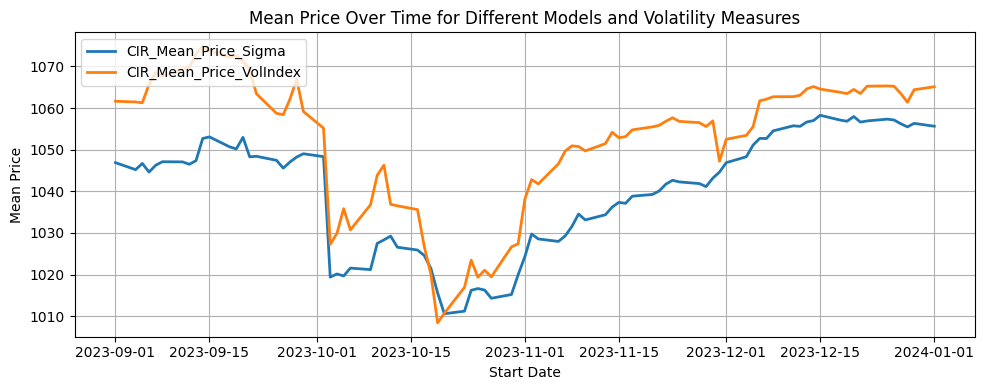

In [ ]:
def plot_price_chart(price_chart):
    plt.figure(figsize=(10, 4))

    # Iterate over each column and plot it
    for column in price_chart.columns:
        plt.plot(price_chart.index, price_chart[column], label=column, linewidth=2)

    plt.xlabel('Start Date')
    plt.ylabel('Mean Price')
    plt.title('Mean Price Over Time for Different Models and Volatility Measures')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function with the price_chart dataframe
plot_price_chart(price_chart[['CIR_Mean_Price_Sigma', 'CIR_Mean_Price_VolIndex']])

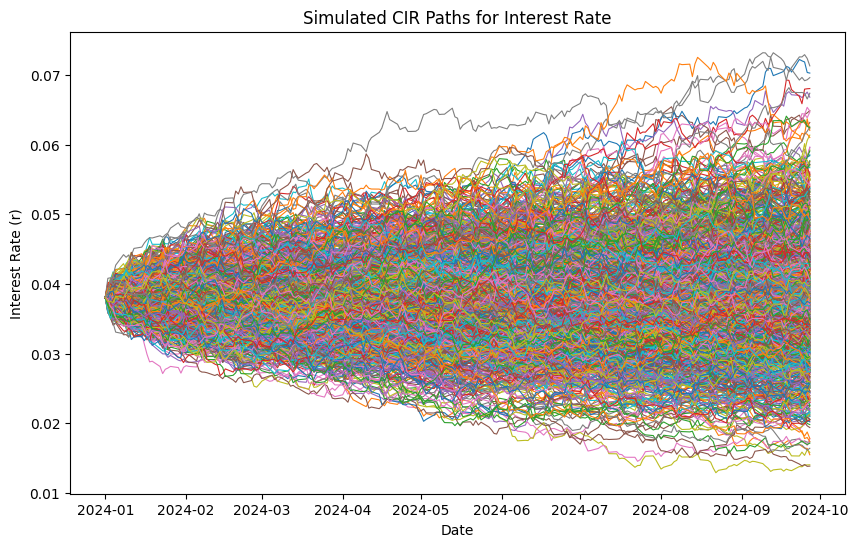

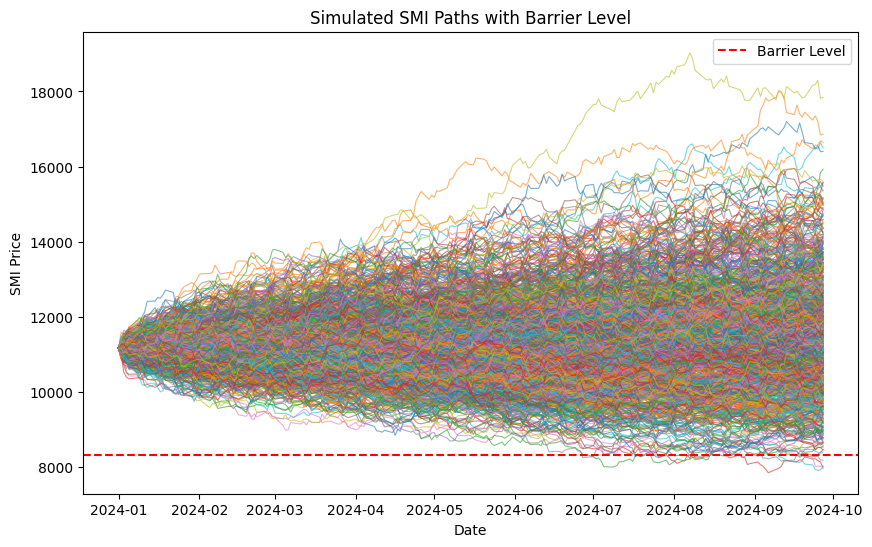

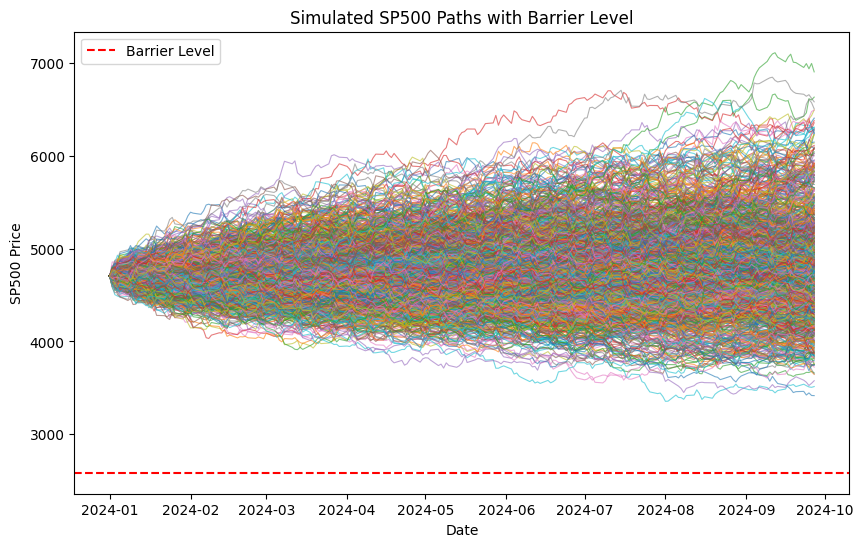

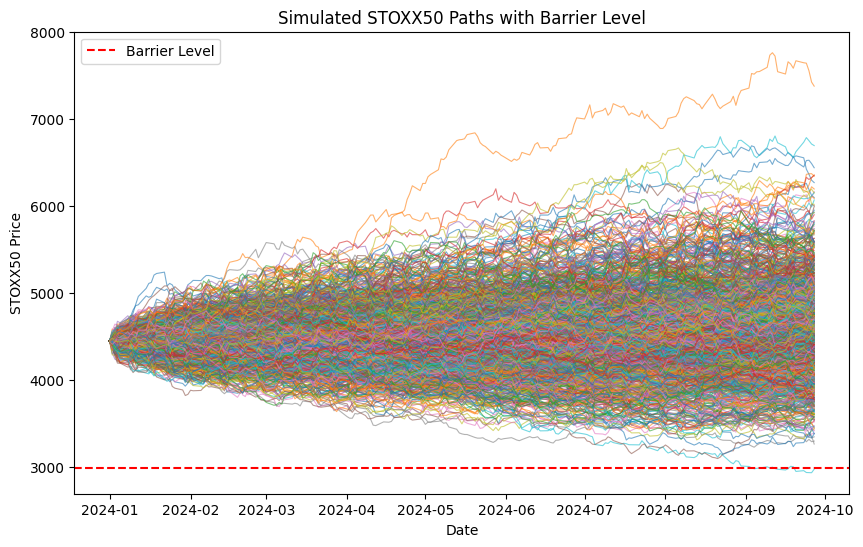

In [ ]:
## Checking if model is working correctly.

start_date = pd.to_datetime('2024-01-01')
dates = pd.bdate_range(start = start_date, end = final_date+pd.to_timedelta("1d"))
n_simulations = 1000
price_paths, r_paths = simulate_price_paths_with_CIR(start_date, n_simulations= n_simulations)
n_timesteps = len(dates)


sp500_init_level = 3977
stoxx_init_level = 4164
smi_init_level= 10786

eur_usd = eur["Price"][start_date]
chf_usd = chf["Price"][start_date]
stoxx_init_level = stoxx_init_level_local / eur_usd
smi_init_level = smi_init_level_local / chf_usd
sp500_barrier = sp500_init_level * 0.65
stoxx_barrier = stoxx_init_level * 0.65
smi_barrier = smi_init_level * 0.65
import matplotlib.pyplot as plt

# --- Plot Interest Rate Paths ---
plt.figure(figsize=(10, 6))
for i in range(n_simulations-1):
    plt.plot(dates, r_paths.transpose()[i], lw=0.8)
plt.xlabel("Date")
plt.ylabel("Interest Rate (r)")
plt.title("Simulated CIR Paths for Interest Rate")
plt.show()

# --- Plot SMI Price Paths with Barrier Line ---
plt.figure(figsize=(10, 6))
for i in range(n_simulations-1):
    plt.plot(dates, price_paths['SMI'][i, :], lw=0.8, alpha=0.6)
# Add barrier line
plt.axhline(y=smi_barrier, color='r', linestyle='--', label='Barrier Level')
plt.xlabel("Date")
plt.ylabel("SMI Price")
plt.title("Simulated SMI Paths with Barrier Level")
plt.legend()
plt.show()

# --- Plot SP500 Price Paths with Barrier Line ---
plt.figure(figsize=(10, 6))
for i in range(n_simulations-1):
    plt.plot(dates, price_paths['SP500'][i, :], lw=0.8, alpha=0.6)
# Add barrier line
plt.axhline(y=sp500_barrier, color='r', linestyle='--', label='Barrier Level')
plt.xlabel("Date")
plt.ylabel("SP500 Price")
plt.title("Simulated SP500 Paths with Barrier Level")
plt.legend()
plt.show()

# --- Plot STOXX50 Price Paths with Barrier Line ---
plt.figure(figsize=(10, 6))
for i in range(n_simulations-1):
    plt.plot(dates, price_paths['STOXX50'][i, :], lw=0.8, alpha=0.6)
# Add barrier line
plt.axhline(y=stoxx_barrier, color='r', linestyle='--', label='Barrier Level')
plt.xlabel("Date")
plt.ylabel("STOXX50 Price")
plt.title("Simulated STOXX50 Paths with Barrier Level")
plt.legend()
plt.show()

In [ ]:
x = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)
np.mean(x)

np.float64(1066.7616882310954)

## Delta Calculation

In [ ]:
final_date = pd.to_datetime('2024-09-26')
start_date = pd.to_datetime('2023-09-01')
dates = pd.bdate_range(start = start_date, end = '2024-01-01')
delta_chart = pd.DataFrame({"Start_Date":[], "sp500_delta":[], "smi_delta":[], "stoxx50_delta":[]})
h = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}
price_data = {
        'SMI': smi,
        'STOXX50': stoxx50,
        'SP500': sp500
    }

for start_date in dates:
    if start_date in delta_chart["Start_Date"]: continue
    nsim = 200000
    sigma = {}
    for index in ['SMI', 'STOXX50', 'SP500']:
        #variance = returns[index].var(ddof= 1)*252
        t = vol_index.get(index)
        vol = t[t.index > start_date].iloc[-1].item()
        sigma[index] = vol/100
    h = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}
    deltas = {}
    initial_prices = {}
    for index in price_data:
        initial_prices[index] = price_data[index]['Price'][price_data[index].index >= start_date].iloc[-1]
    for i in h:
        h = {'SMI': 1.0,'STOXX50':1.0, 'SP500':1.0}
        h_percent = 0.05
        h[i] = 1.0 + h_percent
        price_paths, _ = simulate_price_paths_with_CIR(start_date, n_simulations= nsim, h_percentage_change= h)
        cir = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)
        upper_price = np.mean(cir)
        h[i] = 1.0 - h_percent
        price_paths, _ = simulate_price_paths_with_CIR(start_date, n_simulations= nsim, h_percentage_change= h)
        cir = price_barrier_reverse_convertible(start_date = start_date, price_paths=price_paths)
        lower_price = np.mean(cir)
        epsilon = initial_prices.get(i)*h_percent
        deltas[i] = (upper_price-lower_price)/(2*epsilon)

    delta_chart.loc[len(delta_chart)+1] = {"Start_Date": start_date,
                                           "sp500_delta":deltas.get("SP500"),
                                           "smi_delta":deltas.get("SMI"),
                                           "stoxx50_delta":deltas.get("STOXX50")}
    print(start_date)


#Needs to have 5000> sims for vaguely accurate results
delta_chart.to_csv("delta_chart_overnight.csv")

2023-09-01 00:00:00
2023-09-04 00:00:00
2023-09-05 00:00:00
2023-09-06 00:00:00
2023-09-07 00:00:00
2023-09-08 00:00:00
2023-09-11 00:00:00
2023-09-12 00:00:00
2023-09-13 00:00:00
2023-09-14 00:00:00
2023-09-15 00:00:00
2023-09-18 00:00:00
2023-09-19 00:00:00
2023-09-20 00:00:00
2023-09-21 00:00:00
2023-09-22 00:00:00
2023-09-25 00:00:00
2023-09-26 00:00:00
2023-09-27 00:00:00
2023-09-28 00:00:00
2023-09-29 00:00:00
2023-10-02 00:00:00
2023-10-03 00:00:00
2023-10-04 00:00:00
2023-10-05 00:00:00
2023-10-06 00:00:00
2023-10-09 00:00:00
2023-10-10 00:00:00
2023-10-11 00:00:00
2023-10-12 00:00:00
2023-10-13 00:00:00
2023-10-16 00:00:00
2023-10-17 00:00:00
2023-10-18 00:00:00
2023-10-19 00:00:00
2023-10-20 00:00:00
2023-10-23 00:00:00
2023-10-24 00:00:00
2023-10-25 00:00:00
2023-10-26 00:00:00
2023-10-27 00:00:00
2023-10-30 00:00:00
2023-10-31 00:00:00
2023-11-01 00:00:00
2023-11-02 00:00:00
2023-11-03 00:00:00
2023-11-06 00:00:00
2023-11-07 00:00:00
2023-11-08 00:00:00
2023-11-09 00:00:00


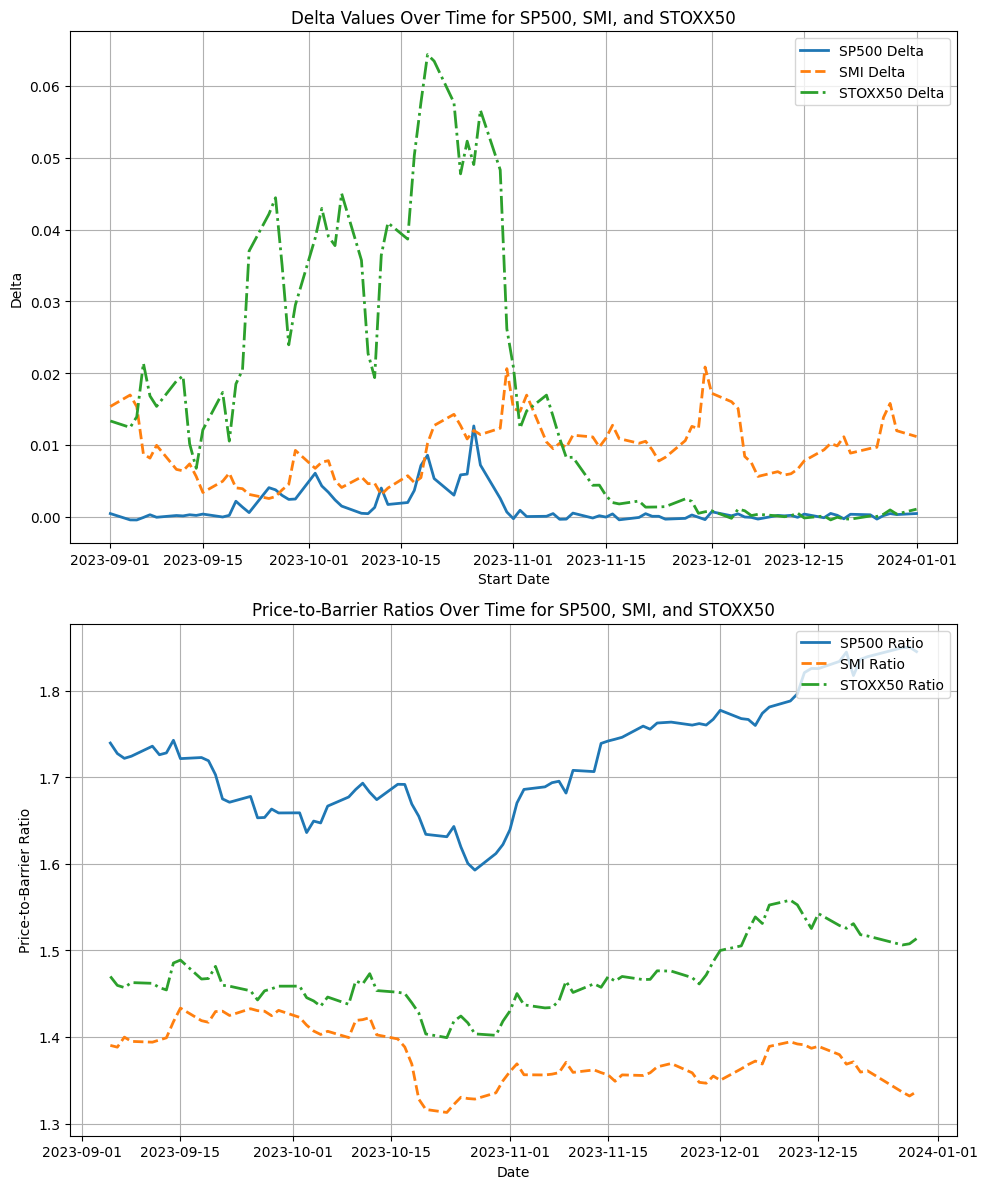

In [ ]:
#delta_chart.set_index("Start_Date", inplace = True)
#Might have to comment out if already set
sp500_init_level = 3977
stoxx_init_level = 4164
smi_init_level= 10786

delta_chart.rename(columns={"sp500_delta":"SP500", 	"smi_delta"	: "SMI", "stoxx50_delta":"STOXX50"}, inplace = True)

start_date = pd.to_datetime('2023-09-01')
end_date = pd.to_datetime('2024-01-01')

# Step 2: Filter the data for the specified timeframe
smi1 = smi[(smi.index > start_date) & (smi.index < end_date)]["Price"]
stoxx501 = stoxx50[(stoxx50.index > start_date) & (stoxx50.index < end_date)]["Price"]
sp5001 = sp500[(sp500.index > start_date) & (sp500.index < end_date)]["Price"]

# Step 3: Calculate the barriers
smi_barrier_df = smi_init_level * 0.65 / chf["Price"]
stoxx50_barrier_df = stoxx_init_level * 0.65 / eur["Price"]
sp500_barrier_df = sp500_barrier  # Assuming `sp500_barrier` contains the barrier price directly

# Step 4: Align filtered data with respective barriers
smi_filtered = smi1[smi1.index.isin(smi_barrier_df.index)]
smi_barrier_filtered = smi_barrier_df[smi_barrier_df.index.isin(smi_filtered.index)]

stoxx50_filtered = stoxx501[stoxx501.index.isin(stoxx50_barrier_df.index)]
stoxx50_barrier_filtered = stoxx50_barrier_df[stoxx50_barrier_df.index.isin(stoxx50_filtered.index)]


# Step 5: Calculate the ratios of price to barrier
smi_ratio = smi_filtered / smi_barrier_filtered
stoxx50_ratio = stoxx50_filtered / stoxx50_barrier_filtered
sp500_ratio = sp500["Price"] / sp500_barrier

# Combine the ratios into a DataFrame for easier comparison
ratios_df = pd.DataFrame({
    "SMI Price-to-Barrier Ratio": smi_ratio,
    "STOXX50 Price-to-Barrier Ratio": stoxx50_ratio,
    "SP500 Price-to-Barrier Ratio": sp500_ratio
}).dropna()

# Display the combined DataFrame
ratios_df
def plot_delta_chart_with_ratios(delta_chart):
    plt.figure(figsize=(10, 12))

    # First Plot: Delta Chart
    plt.subplot(2, 1, 1)
    plt.plot(delta_chart.index, delta_chart['SP500'], label='SP500 Delta', linestyle='-', linewidth=2)
    plt.plot(delta_chart.index, delta_chart['SMI'], label='SMI Delta', linestyle='--', linewidth=2)
    plt.plot(delta_chart.index, delta_chart['STOXX50'], label='STOXX50 Delta', linestyle='-.', linewidth=2)
    plt.xlabel('Start Date')
    plt.ylabel('Delta')
    plt.title('Delta Values Over Time for SP500, SMI, and STOXX50')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Second Plot: Ratios Chart
    plt.subplot(2, 1, 2)
    plt.plot(ratios_df.index, ratios_df['SP500 Price-to-Barrier Ratio'], label='SP500 Ratio', linestyle='-', linewidth=2)
    plt.plot(ratios_df.index, ratios_df['SMI Price-to-Barrier Ratio'], label='SMI Ratio', linestyle='--', linewidth=2)
    plt.plot(ratios_df.index, ratios_df['STOXX50 Price-to-Barrier Ratio'], label='STOXX50 Ratio', linestyle='-.', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Price-to-Barrier Ratio')
    plt.title('Price-to-Barrier Ratios Over Time for SP500, SMI, and STOXX50')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()


    # Step 1: Define the timeframe



plot_delta_chart_with_ratios(delta_chart)

## Delta Hedging

In [ ]:
from sklearn.decomposition import PCA
delta_chart.rename(columns={"sp500_delta":"SP500", 	"smi_delta"	: "SMI", "stoxx50_delta":"STOXX50"}, inplace = True)
returns_diff = pd.DataFrame({"SP500": list(sp500["Price"] - sp500["Price"].shift(1)),
                            "SMI": list(smi["Price"] - smi["Price"].shift(1)),
                            "STOXX50": list(stoxx50["Price"] - stoxx50["Price"].shift(1))})
cov_matrix = returns.cov()

cov_array = cov_matrix.values
n_components = 1
pca = PCA(n_components=n_components)

pca.fit(cov_array)
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_.T
print("Explained Variance:", pca.explained_variance_ratio_)
delta_factor = eigenvectors.T @ delta_chart[["SP500","SMI","STOXX50"]].values[0]
## so delta for each factor in pca
print("Delta Factor:",delta_factor)
hedge_positions_factor = -delta_factor
hedge_positions_asset = eigenvectors @ hedge_positions_factor
print("Orignal Hedge:", -delta_chart[["SP500","SMI","STOXX50"]].values[0])
print("Updated Hedge:", hedge_positions_asset)
print("Ignore the first one, i.e no need to hold S&P500 at current levels")
notional_amount = 1000

Explained Variance: [0.68023169]
Delta Factor: [0.00969754]
Orignal Hedge: [-0.00042375 -0.01534446 -0.01333064]
Updated Hedge: [ 0.00260296  0.00176831 -0.00917278]
Ignore the first one, i.e no need to hold S&P500 at current levels


# The Heston-CIR Model

In [ ]:
dt = 1 / 252

def calibrate_heston_params(vol_data):
    def objective(params):
        kappa_v, theta_v, sigma_v, rho_v = params
        mean_vol = np.mean(vol_data)
        var_vol = np.var(vol_data)

        model_mean_vol = theta_v
        model_var_vol = sigma_v ** 2 / (2 * kappa_v)

        return (mean_vol - model_mean_vol) ** 2 + (var_vol - model_var_vol) ** 2

    initial_params = [0.5, 0.04, 0.1, -0.7]
    bounds = [(0.001, None), (0.001, None), (0.001, None), (-1, 1)]
    result = minimize(objective, initial_params, bounds=bounds)
    kappa_v, theta_v, sigma_v, rho_v = result.x
    return kappa_v, theta_v, sigma_v, rho_v

# Calibrate Heston parameters for each index
calibrated_params = {}
for index, vol_data in vol_index.items():
    calibrated_params[index] = calibrate_heston_params(vol_data)

def simulate_price_paths_with_heston_CIR(start_date, n_simulations, vol_index, calibrated_params, h_percentage_change={'SMI': 1.0, 'STOXX50': 1.0, 'SP500': 1.0}):
    start_date = pd.to_datetime(start_date)
    final_date = pd.to_datetime('2024-09-26')
    sim_dates = pd.bdate_range(start=start_date, end=final_date)
    n_timesteps = len(sim_dates)

    initial_prices = {'SMI': 4200, 'STOXX50': 3500, 'SP500': 4500} # Need to replace this with actual data
    for index in initial_prices.keys():
        initial_prices[index] *= h_percentage_change.get(index, 1.0)

    price_paths = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in initial_prices.keys()}
    vol_paths = {index: np.zeros((n_timesteps + 1, n_simulations)) for index in initial_prices.keys()}
    r_paths = np.zeros((n_timesteps + 1, n_simulations))

    for index in price_paths.keys():
        price_paths[index][0] = initial_prices[index]
        vol_paths[index][0] = calibrated_params[index][1]  # Use theta as the initial variance
    r_paths[0] = 0.03

    for i in range(1, n_timesteps + 1):
        Z_r = np.random.normal(size=n_simulations)
        r_prev = r_paths[i - 1]
        dr = kappa * (theta - r_prev) * dt + sigma_r * np.sqrt(r_prev * dt) * Z_r
        r_paths[i] = np.maximum(r_prev + dr, 0)

        for index in price_paths.keys():
            kappa_v, theta_v, sigma_v, rho_v = calibrated_params[index]

            corr_matrix = np.array([[1, rho_v], [rho_v, 1]])
            chol_matrix = np.linalg.cholesky(corr_matrix)
            Z = np.random.normal(size=(n_timesteps, n_simulations, 2))
            Z_flat = Z.reshape(-1, 2)
            Z_correlated_flat = Z_flat @ chol_matrix.T
            Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, 2)

            v_prev = vol_paths[index][i - 1]
            dv = kappa_v * (theta_v - v_prev) * dt + sigma_v * np.sqrt(v_prev * dt) * Z_correlated[i - 1, :, 0]
            vol_paths[index][i] = np.maximum(v_prev + dv, 0)

            drift_term = (r_paths[i] - 0.5 * vol_paths[index][i]) * dt
            diffusion_term = np.sqrt(vol_paths[index][i] * dt) * Z_correlated[i - 1, :, 1]
            price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)

    for index in price_paths.keys():
        price_paths[index] = price_paths[index].transpose()
        vol_paths[index] = vol_paths[index].transpose()
    return price_paths, vol_paths, r_paths


start_date = '2024-01-01'
price_paths, vol_paths, r_paths = simulate_price_paths_with_heston_CIR(
    start_date, n_simulations=100, vol_index=vol_index, calibrated_params=calibrated_params
)

print(price_paths)
print(vol_paths)
print(r_paths)